In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!unzip -q "/content/gdrive/MyDrive/BTP_Venkat/New_Cropped_inputs.zip"
!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py39_4.9.2-Linux-x86_64.sh
!chmod +x mini.sh
!bash ./mini.sh -b -f -p /usr/local

!conda install -q -y jupyter
!conda install -q -y google-colab -c conda-forge
!python -m ipykernel install --name "py39" --user

In [ ]:
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
# %pip install torchsampler
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import numpy as np
import random
import torch
import os
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np
import torch


In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    random.Random(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
seed = 42
set_seed(seed)


Random seed set as 42


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
p = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0 ,0 , 1, 1, 1, 1, 1, 1, 0, 0, 0]
p1 = [0 for i in range(90)]
p2 = [1 for i in range(80)]
p = p + p1 + p2
p = np.array(p)

In [ ]:
p = torch.from_numpy(p)
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir,  transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image_matrix = np.load(os.path.join('New_Cropped_inputs/Pot_{}_Input_Seq_Cropped.npy'.format(idx+1 if idx>=9 else '0'+str(idx+1))), allow_pickle=True)
        # image_matrix=np.vstack(image_matrix).astype(np.float64)
        image_matrix=np.array(image_matrix, dtype=[('O', np.float64)]).astype(np.float64)
        label = self.img_labels[idx]
        cropped_img_matrix = []
        if self.transform is not None:
          for image in image_matrix:
            # image = self.transform(image=image)["image"]
            # print(self.transform(image=image)["image"].shape)
            cropped_img_matrix.append(self.transform(image=image)["image"])
        my_tensor = torch.stack(cropped_img_matrix)
        # image_matrix = torch.from_numpy(image_matrix)


        return my_tensor, label

val_transform = A.Compose(
    [
        # A.CenterCrop(height=224, width=224),
        # A.CenterCrop(height=512, width=512),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.9),
        # A.RandomBrightnessContrast(p=0.5),
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
transformed_dataset = CustomImageDataset(annotations_file=p, img_dir='New_Cropped_inputs', transform=val_transform)

In [ ]:
len(transformed_dataset)

200

In [ ]:
def visualize_rgb_images(images):
    # Convert tensors to numpy arrays
    images = [np.transpose(img.numpy(), (1, 2, 0)) for img in images]
    fig, axs = plt.subplots(1, len(images), figsize=(25, 25))
    # print(images.shape)

    for i, img in enumerate(images):
        # print(img)
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()

def vis_datasets_sequences(dataset):
  for count, img in enumerate(dataset):
    print("Pot: ",count+1, "Label: ",img[1])
    visualize_rgb_images(img[0])

In [ ]:
# vis_datasets_sequences(transformed_dataset)

In [ ]:
p = p.tolist()

def argsort(seq):
    # http://stackoverflow.com/questions/3071415/efficient-method-to-calculate-the-rank-vector-of-a-list-in-python
    return sorted(range(len(seq)), key=seq.__getitem__)
training_arr1 = argsort([-x for x in p])


training_arr = []
test_arr = [28, 18, 14, 17, 2, 4, 7, 11, 9, 21, 24]



for i in training_arr1:
  if i in test_arr:
    continue
  else:
    training_arr.append(i)
# training_arr = list(set(training_arr) - set(test_arr))


In [ ]:
def calculate_metrics(predictions, truths):
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    for i in range(len(predictions)):
        if predictions[i] == 1 and truths[i] == 1:
            tp += 1
        elif predictions[i] == 1 and truths[i] == 0:
            fp += 1
        elif predictions[i] == 0 and truths[i] == 0:
            tn += 1
        elif predictions[i] == 0 and truths[i] == 1:
            fn += 1

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    accuracy = (tp + tn) / (tp + fp + tn + fn) if tp + fp + tn + fn > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, accuracy, f1_score

In [ ]:
import time
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias, device):
        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        self.device = device
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        h_cur, c_cur = h_cur.to(self.device), c_cur.to(self.device)
        combined = torch.cat([input_tensor, h_cur], dim=1)

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width).to(self.device),
                torch.zeros(batch_size, self.hidden_dim, height, width).to(self.device))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size,device,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []

        cur_input_dim = self.input_dim
        self.sigmoid = nn.Sigmoid()
        self.device = device


        self.conv_lstm = ConvLSTMCell(input_dim=cur_input_dim,
                                      hidden_dim=self.hidden_dim,
                                      kernel_size=self.kernel_size,
                                          bias=self.bias, device = self.device)

        self.conv1 = nn.Conv2d(self.hidden_dim, 20, 3)
        self.pool1 = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(20, 40, 3)
        self.fc1 = nn.Linear(40*13*13, 1)
    def forward(self, input_tensor):
        starttime = time.time()
        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        h, c = self._init_hidden(input_tensor.size(0), (input_tensor.size(3), input_tensor.size(4)))
        h,c = h.to(self.device), c.to(self.device)
        for t in range(seq_len):
            h, c = self.conv_lstm(input_tensor=cur_layer_input[:, t, :, :, :],
                                              cur_state=[h, c])

        y = h
        y = self.pool1(F.relu(self.conv1(y)))
        y = self.pool1(F.relu(self.conv2(y)))
        out = y.view(-1, 40*13*13)
        out = self.sigmoid(self.fc1(out))
        print('Time: ',time.time() - starttime)
        return out[0]

        out = out.view(1, -1)
        out = out[:,-1]
        return out[0][0][0]       # out, hidden = self.lstm1(y.view(-1, 10920), hidden)

    def _init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width).to(self.device),
                torch.zeros(batch_size, self.hidden_dim, height, width).to(self.device))

In [ ]:
input_dim, hidden_dim, kernel_size = 3, 10, (3,3)

model = ConvLSTM(input_dim, hidden_dim, kernel_size, device)
model = model.to(device)

In [ ]:
model.parameters()


<generator object Module.parameters at 0x7f7e79cb8f20>

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
pytorch_total_params

20541

In [ ]:
for i in range(100):
  dummy_input = torch.randn(16,3,224,224, dtype=torch.float).to(device)
  model(dummy_input.unsqueeze(0))

Time:  0.0178377628326416
Time:  0.00790858268737793
Time:  0.007174015045166016
Time:  0.007200002670288086
Time:  0.007304668426513672
Time:  0.007315158843994141
Time:  0.007320404052734375
Time:  0.008979082107543945
Time:  0.008941173553466797
Time:  0.007723331451416016
Time:  0.0073354244232177734
Time:  0.010192632675170898
Time:  0.011717796325683594
Time:  0.011668920516967773
Time:  0.010513067245483398
Time:  0.0125732421875
Time:  0.01160740852355957
Time:  0.01103353500366211
Time:  0.029590368270874023
Time:  0.010607004165649414
Time:  0.014886140823364258
Time:  0.010398626327514648
Time:  0.010366439819335938
Time:  0.0100860595703125
Time:  0.010029315948486328
Time:  0.010309696197509766
Time:  0.011183023452758789
Time:  0.010125875473022461
Time:  0.010442018508911133
Time:  0.010295629501342773
Time:  0.010857105255126953
Time:  0.01036977767944336
Time:  0.010027647018432617
Time:  0.010629415512084961
Time:  0.011118173599243164
Time:  0.011553525924682617
Time

In [ ]:
dummy_input = torch.randn(16,3,224,224, dtype=torch.float).to(device)
repetitions=100
total_time = 0
with torch.no_grad():
    for rep in range(repetitions):
        starter, ender = torch.cuda.Event(enable_timing=True),   torch.cuda.Event(enable_timing=True)
        starter.record()
        _ = model(dummy_input.unsqueeze(0))
        ender.record()
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)/1000
        total_time += curr_time
Throughput =   (repetitions)/total_time
print('Final Throughput:',Throughput)

Final Throughput: 12.74704482037331


In [ ]:
while seed <=150:
  print(seed)
  training_arr_randomized = training_arr.copy()
  random.Random(seed).shuffle(training_arr_randomized)

  training_arr_randomized_without_random_seq = [i for i in training_arr_randomized if i<=29]
  train_dataset_randomized_with_random_seq = Subset(transformed_dataset,training_arr_randomized)
  train_dataset_randomized_without_random_seq = Subset(transformed_dataset,training_arr_randomized_without_random_seq)

  test_dataset = Subset(transformed_dataset,test_arr)

  input_dim, hidden_dim, kernel_size = 3, 10, (3,3)

  model_conv_with = ConvLSTM(input_dim, hidden_dim, kernel_size, device)
  model_conv_with = model_conv_with.to(device)

  model_conv_without = ConvLSTM(input_dim, hidden_dim, kernel_size, device)
  model_conv_without = model_conv_without.to(device)

  lr=0.0001
  criterion = nn.BCELoss()
  optimizer_with = torch.optim.Adam(model_conv_with.parameters(), lr=lr)
  optimizer_without = torch.optim.Adam(model_conv_without.parameters(), lr=lr)

  no_of_epochs = 5
  loss_list_with = []

  for epoch in range(no_of_epochs):
      print('-------------------Epoch_{}----------------------------------'.format(epoch+1))

      for index, (inputs, labels) in enumerate(train_dataset_randomized_with_random_seq):
            # print(type(labels))

            # print('-------------------------------------------------------------')
            inputs, labels = inputs.to(device).float(), labels.to(device).float()

            model_conv_with.zero_grad()
            output = model_conv_with(inputs.unsqueeze(0))

            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            optimizer_with.step()
            loss_list_with.append(loss.item())

  num_correct_with = 0
  pred_with_arr = []
  truth_with_arr = []

  with torch.no_grad():
    for inputs, labels in test_dataset:
        print('-----------------------------------------------------')
        inputs, labels = inputs.to(device).float(), labels.to(device).float()
        output = model_conv_with(inputs.unsqueeze(0))
        print('Predicted Sigmoid: ', output.squeeze().item())

        pred = torch.round(output.squeeze())
        correct_tensor = pred.eq(labels.float().view_as(pred))
        print('Predicted Label: ', pred)
        print('Truth: ', labels)
        pred_with_arr.append(pred.detach().cpu().numpy())
        truth_with_arr.append(labels.detach().cpu().numpy())
        if int(pred.item()) == labels:
          num_correct_with += 1

  print("Accuracy with Random Seq Splicing: ", num_correct_with/len(test_dataset))

  # print('Predicted Array:', pred_with_arr)
  # print('Truth Array:', truth_with_arr)

  p, r, a, f1 = calculate_metrics(pred_with_arr, truth_with_arr)
  print(a)

  # torch.save(model_conv_with.state_dict(), '/content/gdrive/MyDrive/BTP_Venkat/ConvLSTM/Sequence/{}_{}_A_S_zero.pt'.format("%.2f" % a, seed))

  no_of_epochs = 5
  loss_list_without = []

  for epoch in range(no_of_epochs):
      print('-------------------Epoch_{}----------------------------------'.format(epoch+1))

      for index, (inputs, labels) in enumerate(train_dataset_randomized_without_random_seq):
            inputs, labels = inputs.to(device).float(), labels.to(device).float()
            model_conv_without.zero_grad()
            output = model_conv_without(inputs.unsqueeze(0))
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            optimizer_without.step()
            loss_list_without.append(loss.item())


  num_correct_without = 0
  pred_without_arr = []
  truth_without_arr = []
  with torch.no_grad():
    for inputs, labels in test_dataset:
        print('-----------------------------------------------------')
        inputs, labels = inputs.to(device).float(), labels.to(device).float()
        output = model_conv_without(inputs.unsqueeze(0))


        pred = torch.round(output.squeeze())
        correct_tensor = pred.eq(labels.float().view_as(pred))
        pred_without_arr.append(pred.detach().cpu().numpy())
        truth_without_arr.append(labels.detach().cpu().numpy())
        if int(pred.item()) == labels:
          num_correct_without += 1

  print("Accuracy with Random Seq Splicing: ", num_correct_without/len(test_dataset))

  p1, r1, a1, f11 = calculate_metrics(pred_without_arr, truth_without_arr)
  print(a1)

  # torch.save(model_conv_without.state_dict(), '/content/gdrive/MyDrive/BTP_Venkat/ConvLSTM/Original/{}_{}_A_S_zero.pt'.format("%.2f" % a1, seed))

  # seed+=3
  break


42
-------------------Epoch_1----------------------------------
-------------------Epoch_2----------------------------------
-------------------Epoch_3----------------------------------
-------------------Epoch_4----------------------------------
-------------------Epoch_5----------------------------------
-----------------------------------------------------
Predicted Sigmoid:  0.028854159638285637
Predicted Label:  tensor(0., device='cuda:0')
Truth:  tensor(0., device='cuda:0')
-----------------------------------------------------
Predicted Sigmoid:  0.006123712286353111
Predicted Label:  tensor(0., device='cuda:0')
Truth:  tensor(0., device='cuda:0')
-----------------------------------------------------
Predicted Sigmoid:  0.013238147832453251
Predicted Label:  tensor(0., device='cuda:0')
Truth:  tensor(0., device='cuda:0')
-----------------------------------------------------
Predicted Sigmoid:  0.007655692752450705
Predicted Label:  tensor(0., device='cuda:0')
Truth:  tensor(1., d

In [ ]:
p

1.0

In [ ]:
training_arr1 = argsort([ -x for x in p])

training_arr = []
test_arr = [28, 18, 14, 17, 2, 4, 7, 11, 9, 21, 24]

for i in training_arr1:
  if i in test_arr:
    continue
  else:
    training_arr.append(i)
# training_arr = list(set(training_arr) - set(test_arr))

TypeError: ignored

In [ ]:
while seed == 42:
  print(seed)
  training_arr_randomized = training_arr.copy()
  random.Random(seed).shuffle(training_arr_randomized)

  training_arr_randomized_without_random_seq = [i for i in training_arr_randomized if i<=29]
  train_dataset_randomized_with_random_seq = Subset(transformed_dataset,training_arr_randomized)
  train_dataset_randomized_without_random_seq = Subset(transformed_dataset,training_arr_randomized_without_random_seq)

  test_dataset = Subset(transformed_dataset,test_arr)

  input_dim, hidden_dim, kernel_size = 3, 10, (3,3)

  model_conv_with = ConvLSTM(input_dim, hidden_dim, kernel_size, device)
  model_conv_with = model_conv_with.to(device)

  model_conv_without = ConvLSTM(input_dim, hidden_dim, kernel_size, device)
  model_conv_without = model_conv_without.to(device)

  lr=0.0001
  criterion = nn.BCELoss()
  optimizer_with = torch.optim.Adam(model_conv_with.parameters(), lr=lr)
  optimizer_without = torch.optim.Adam(model_conv_without.parameters(), lr=lr)

  no_of_epochs = 5
  loss_list_with = []
  print(len(train_dataset_randomized_with_random_seq))
  for epoch in range(no_of_epochs):
      print('-------------------Epoch_{}----------------------------------'.format(epoch+1))

      for index, (inputs, labels) in enumerate(train_dataset_randomized_with_random_seq):
            # print('-------------------------------------------------------------')
            inputs, labels = inputs.to(device).float(), labels.to(device).float()

            model_conv_with.zero_grad()
            output = model_conv_with(inputs.unsqueeze(0))

            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            optimizer_with.step()
            loss_list_with.append(loss.item())

  num_correct_with = 0
  pred_with_arr = []
  truth_with_arr = []

  with torch.no_grad():
    for inputs, labels in test_dataset:
        print('-----------------------------------------------------')
        inputs, labels = inputs.to(device).float(), labels.to(device).float()
        output = model_conv_with(inputs.unsqueeze(0))
        print('Predicted Sigmoid: ', output.squeeze().item())

        pred = torch.round(output.squeeze())
        correct_tensor = pred.eq(labels.float().view_as(pred))
        print('Predicted Label: ', pred)
        print('Truth: ', labels)
        pred_with_arr.append(pred.detach().cpu().numpy())
        truth_with_arr.append(labels.detach().cpu().numpy())
        if int(pred.item()) == labels:
          num_correct_with += 1

  print("Accuracy with Random Seq Splicing: ", num_correct_with/len(test_dataset))

  # print('Predicted Array:', pred_with_arr)
  # print('Truth Array:', truth_with_arr)

  p, r, a, f1 = calculate_metrics(pred_with_arr, truth_with_arr)
  print(a)

  # torch.save(model_conv_with.state_dict(), '/content/gdrive/MyDrive/BTP_Venkat/ConvLSTM/Sequence/{}_{}_A_S_one.pt'.format("%.2f" % a, seed))

  no_of_epochs = 5
  loss_list_without = []

  for epoch in range(no_of_epochs):
      print('-------------------Epoch_{}----------------------------------'.format(epoch+1))

      for index, (inputs, labels) in enumerate(train_dataset_randomized_without_random_seq):
            inputs, labels = inputs.to(device).float(), labels.to(device).float()
            model_conv_without.zero_grad()
            output = model_conv_without(inputs.unsqueeze(0))
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            optimizer_without.step()
            loss_list_without.append(loss.item())


  num_correct_without = 0
  pred_without_arr = []
  truth_without_arr = []
  with torch.no_grad():
    for inputs, labels in test_dataset:
        print('-----------------------------------------------------')
        inputs, labels = inputs.to(device).float(), labels.to(device).float()
        output = model_conv_without(inputs.unsqueeze(0))


        pred = torch.round(output.squeeze())
        correct_tensor = pred.eq(labels.float().view_as(pred))
        pred_without_arr.append(pred.detach().cpu().numpy())
        truth_without_arr.append(labels.detach().cpu().numpy())
        if int(pred.item()) == labels:
          num_correct_without += 1

  print("Accuracy with Random Seq Splicing: ", num_correct_without/len(test_dataset))

  p1, r1, a1, f11 = calculate_metrics(pred_without_arr, truth_without_arr)
  print(a1)

  # torch.save(model_conv_without.state_dict(), '/content/gdrive/MyDrive/BTP_Venkat/ConvLSTM/Original/{}_{}_A_S_one.pt'.format("%.2f" % a1, seed))

  seed+=3


In [ ]:
print(p, r, a, f1)

print(p1, r1, a1, f11)

In [ ]:
training_arr_randomized = training_arr.copy()
random.Random(seed).shuffle(training_arr_randomized)

training_arr_randomized_without_random_seq = [i for i in training_arr_randomized if i<=29]
train_dataset_randomized_with_random_seq = Subset(transformed_dataset,training_arr_randomized)
train_dataset_randomized_without_random_seq = Subset(transformed_dataset,training_arr_randomized_without_random_seq)

test_dataset = Subset(transformed_dataset,test_arr)

input_dim, hidden_dim, kernel_size = 3, 10, (3,3)


lr=0.0001
criterion = nn.BCELoss()
optimizer_with = torch.optim.Adam(model_conv_with.parameters(), lr=lr)
optimizer_without = torch.optim.Adam(model_conv_without.parameters(), lr=lr)

In [ ]:
training_arr_randomized = training_arr.copy()
random.Random(seed).shuffle(training_arr_randomized)

In [ ]:
# print(len(training_arr))
# print(len(training_arr_randomized))
# print(len(training_arr_randomized_without_random_seq))

# print(training_arr)
# print(training_arr_randomized)
# print(training_arr_randomized_without_random_seq)

In [ ]:
training_arr_randomized_without_random_seq = [i for i in training_arr_randomized if i<=29]

train_dataset_randomized_with_random_seq = Subset(transformed_dataset,training_arr_randomized)
train_dataset_randomized_without_random_seq = Subset(transformed_dataset,training_arr_randomized_without_random_seq)

test_dataset = Subset(transformed_dataset,test_arr)

In [ ]:
device = torch.device("cuda")

In [ ]:
no_of_epochs = 5
loss_list_with = []

# model.train()
for epoch in range(no_of_epochs):
    # running_loss = 0.0
    print('-------------------Epoch_{}----------------------------------'.format(epoch+1))

    # for inputs, labels in train_dataset:
    for index, (inputs, labels) in enumerate(train_dataset_randomized_with_random_seq):
          print('-------------------------------------------------------------')
          inputs, labels = inputs.to(device).float(), labels.to(device).float()

          model_conv_with.zero_grad()
          print(inputs.shape)
          output = model_conv_with(inputs.unsqueeze(0))
          print('Pot',index)
          print('Input Shape: ', inputs.unsqueeze(0).shape)
          print('Pot: ', output)

          print('Predicted Sigmoid',output.squeeze().item(),'Truth Label', labels.item())
          print(labels.float().shape)
          loss = criterion(output.squeeze(), labels.float())
          loss.backward()
          optimizer_with.step()
          print('Loss', loss.item())
          loss_list_with.append(loss.item())
          # if epoch == 100 or epoch == 200 or epoch == 300 or epoch == 400 or epoch == 500 or epoch == 50 :
          #   torch.save(model_conv.state_dict(), './state_dict_{}.pt'.format(epoch))
          #   np.savez("./losslist_{}".format(epoch), np.array(loss_list))
          # print('------------------------------------------------------')

print('done')

Streaming output truncated to the last 5000 lines.
Pot:  tensor([0.4747], device='cuda:0', grad_fn=<SelectBackward0>)
Predicted Sigmoid 0.4747180640697479 Truth Label 0.0
torch.Size([])
Loss 0.6438202261924744
-------------------------------------------------------------
torch.Size([16, 3, 224, 224])
Pot 132
Input Shape:  torch.Size([1, 16, 3, 224, 224])
Pot:  tensor([0.7026], device='cuda:0', grad_fn=<SelectBackward0>)
Predicted Sigmoid 0.7025840282440186 Truth Label 1.0
torch.Size([])
Loss 0.3529902696609497
-------------------------------------------------------------
torch.Size([16, 3, 224, 224])
Pot 133
Input Shape:  torch.Size([1, 16, 3, 224, 224])
Pot:  tensor([0.6708], device='cuda:0', grad_fn=<SelectBackward0>)
Predicted Sigmoid 0.6707649230957031 Truth Label 1.0
torch.Size([])
Loss 0.3993365466594696
-------------------------------------------------------------
torch.Size([16, 3, 224, 224])
Pot 134
Input Shape:  torch.Size([1, 16, 3, 224, 224])
Pot:  tensor([0.3869], device='

In [ ]:
no_of_epochs = 5
loss_list_without = []

# model.train()
for epoch in range(no_of_epochs):
    # running_loss = 0.0
    print('-------------------Epoch_{}----------------------------------'.format(epoch+1))

    # for inputs, labels in train_dataset:
    for index, (inputs, labels) in enumerate(train_dataset_randomized_without_random_seq):
          print(inputs.shape)
          print('-------------------------------------------------------------')
          inputs, labels = inputs.to(device).float(), labels.to(device).float()

          model_conv_without.zero_grad()
          print(inputs.shape)
          output = model_conv_without(inputs.unsqueeze(0))
          print('Pot',index)
          print('Input Shape: ', inputs.unsqueeze(0).shape)
          print('Pot: ', output)

          print('Predicted Sigmoid',output.squeeze().item(),'Truth Label', labels.item())
          print(labels.float().shape)
          loss = criterion(output.squeeze(), labels.float())
          loss.backward()
          optimizer_without.step()
          print('Loss', loss.item())
          loss_list_without.append(loss.item())
print('done')

-------------------Epoch_1----------------------------------
torch.Size([16, 3, 224, 224])
-------------------------------------------------------------
torch.Size([16, 3, 224, 224])
Pot 0
Input Shape:  torch.Size([1, 16, 3, 224, 224])
Pot:  tensor([0.5100], device='cuda:0', grad_fn=<SelectBackward0>)
Predicted Sigmoid 0.5100229382514954 Truth Label 1.0
torch.Size([])
Loss 0.6732995510101318
torch.Size([16, 3, 224, 224])
-------------------------------------------------------------
torch.Size([16, 3, 224, 224])
Pot 1
Input Shape:  torch.Size([1, 16, 3, 224, 224])
Pot:  tensor([0.5141], device='cuda:0', grad_fn=<SelectBackward0>)
Predicted Sigmoid 0.5140953660011292 Truth Label 1.0
torch.Size([])
Loss 0.6653465032577515
torch.Size([16, 3, 224, 224])
-------------------------------------------------------------
torch.Size([16, 3, 224, 224])
Pot 2
Input Shape:  torch.Size([1, 16, 3, 224, 224])
Pot:  tensor([0.5200], device='cuda:0', grad_fn=<SelectBackward0>)
Predicted Sigmoid 0.519960224

In [ ]:
input_dim, hidden_dim, kernel_size = 3, 10, (3,3)

model_conv_with = ConvLSTM(input_dim, hidden_dim, kernel_size, device)
model_conv_with = model_conv_with.to(device)

model_conv_without = ConvLSTM(input_dim, hidden_dim, kernel_size, device)
model_conv_without = model_conv_without.to(device)

In [ ]:
lr=0.0001
criterion = nn.BCELoss()
optimizer_with = torch.optim.Adam(model_conv_with.parameters(), lr=lr)
optimizer_without = torch.optim.Adam(model_conv_without.parameters(), lr=lr)

#Training Model with Random Seq Splicing

In [ ]:
num_correct_with = 0
pred_with_arr = []
truth_with_arr = []

with torch.no_grad():
  for inputs, labels in test_dataset:
      print('-----------------------------------------------------')
      inputs, labels = inputs.to(device).float(), labels.to(device).float()
      output = model_conv_with(inputs.unsqueeze(0))
      print('Predicted Sigmoid: ', output.squeeze().item())

      pred = torch.round(output.squeeze())
      correct_tensor = pred.eq(labels.float().view_as(pred))
      print('Predicted Label: ', pred)
      print('Truth: ', labels)
      pred_with_arr.append(pred.detach().cpu().numpy())
      truth_with_arr.append(labels.detach().cpu().numpy())
      if int(pred.item()) == labels:
        num_correct_with += 1

print("Accuracy with Random Seq Splicing: ", num_correct_with/len(test_dataset))
print('Predicted Array:', pred_with_arr)
print('Truth Array:', truth_with_arr)

In [ ]:
# torch.save(model_conv_with.state_dict(), '/content/gdrive/MyDrive/BTP_Venkat/ConvLSTM/With_rand_seq_splicing_Epoch_{}_Seed_{}.pt'.format(no_of_epochs, seed))


#Training without Random Seq Splicing

In [ ]:

num_correct_without = 0
pred_without_arr = []
truth_without_arr = []
with torch.no_grad():
  for inputs, labels in test_dataset:
      print('-----------------------------------------------------')
      inputs, labels = inputs.to(device).float(), labels.to(device).float()
      output = model_conv_without(inputs.unsqueeze(0))

      print('Predicted Sigmoid: ', output.squeeze().item())

      pred = torch.round(output.squeeze())
      correct_tensor = pred.eq(labels.float().view_as(pred))
      print('Predicted Label: ', pred)
      print('Truth: ', labels)
      pred_without_arr.append(pred.detach().cpu().numpy())
      truth_without_arr.append(labels.detach().cpu().numpy())
      if int(pred.item()) == labels:
        num_correct_without += 1

print("Accuracy with Random Seq Splicing: ", num_correct_without/len(test_dataset))
print('Predicted Array:', pred_without_arr)
print('Truth Array:', truth_without_arr)

-----------------------------------------------------
Predicted Sigmoid:  0.5936732888221741
Predicted Label:  tensor(1., device='cuda:0')
Truth:  tensor(0., device='cuda:0')
-----------------------------------------------------
Predicted Sigmoid:  0.5927414298057556
Predicted Label:  tensor(1., device='cuda:0')
Truth:  tensor(0., device='cuda:0')
-----------------------------------------------------
Predicted Sigmoid:  0.5942053198814392
Predicted Label:  tensor(1., device='cuda:0')
Truth:  tensor(0., device='cuda:0')
-----------------------------------------------------
Predicted Sigmoid:  0.5941541194915771
Predicted Label:  tensor(1., device='cuda:0')
Truth:  tensor(1., device='cuda:0')
-----------------------------------------------------
Predicted Sigmoid:  0.6072724461555481
Predicted Label:  tensor(1., device='cuda:0')
Truth:  tensor(1., device='cuda:0')
-----------------------------------------------------
Predicted Sigmoid:  0.6023208498954773
Predicted Label:  tensor(1., dev

In [ ]:
# torch.save(model_conv_without.state_dict(), '/content/gdrive/MyDrive/BTP_Venkat/ConvLSTM/Without_rand_seq_splicing_Epoch_{}_Seed_{}.pt'.format(no_of_epochs, seed))


In [ ]:
def calculate_metrics(predictions, truths):
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    for i in range(len(predictions)):
        if predictions[i] == 1 and truths[i] == 1:
            tp += 1
        elif predictions[i] == 1 and truths[i] == 0:
            fp += 1
        elif predictions[i] == 0 and truths[i] == 0:
            tn += 1
        elif predictions[i] == 0 and truths[i] == 1:
            fn += 1

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    accuracy = (tp + tn) / (tp + fp + tn + fn) if tp + fp + tn + fn > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, accuracy, f1_score

print('P, R, A, F1 with Rand Seq',calculate_metrics(pred_with_arr, truth_with_arr))
print('P, R, A, F1 without Rand Seq',calculate_metrics(pred_without_arr, truth_without_arr))
print('Skewness With Random Seq:', 93/96 )
print('Skewness Without Random Seq:', 13/6 )

P, R, A, F1 with Rand Seq (1.0, 0.75, 0.8181818181818182, 0.8571428571428571)
P, R, A, F1 without Rand Seq (0.7272727272727273, 1.0, 0.7272727272727273, 0.8421052631578948)
Skewness With Random Seq: 0.96875
Skewness Without Random Seq: 2.1666666666666665


#Test Seed 42 Model

In [ ]:
# model_Loaded_42_ConvLSTM = ConvLSTM(input_dim, hidden_dim, kernel_size,device).to(device)
# model_Loaded_42_ConvLSTM.load_state_dict(torch.load('/content/gdrive/MyDrive/BTP_Venkat/ConvLSTM/With_rand_seq_splicing_Epoch_5_Seed_42.pt'), strict= True)
# model_Loaded_42_ConvLSTM.eval()

# for i in range(5):
#   num_correct_with = 0
#   pred_with_arr = []
#   truth_with_arr = []

#   with torch.no_grad():
#     for inputs, labels in test_dataset:
#         # print('-----------------------------------------------------')
#         inputs, labels = inputs.to(device).float(), labels.to(device).float()
#         output = model_Loaded_42_ConvLSTM(inputs.unsqueeze(0))
#         # print('Predicted Sigmoid: ', output.squeeze().item())

#         pred = torch.round(output.squeeze())
#         correct_tensor = pred.eq(labels.float().view_as(pred))
#         # print('Predicted Label: ', pred)
#         # print('Truth: ', labels)
#         pred_with_arr.append(pred.detach().cpu().numpy())
#         truth_with_arr.append(labels.detach().cpu().numpy())
#         if int(pred.item()) == labels:
#           num_correct_with += 1
#   print('P, R, A, F1 with Rand Seq',calculate_metrics(pred_with_arr, truth_with_arr))



In [ ]:
# model_Loaded_42_ConvLSTM_Without = ConvLSTM(input_dim, hidden_dim, kernel_size,device).to(device)
# model_Loaded_42_ConvLSTM_Without.load_state_dict(torch.load('/content/gdrive/MyDrive/BTP_Venkat/ConvLSTM/Without_rand_seq_splicing_Epoch_5_Seed_42.pt'), strict= True)
# model_Loaded_42_ConvLSTM_Without.eval()

# for i in range(5):
#   num_correct_without = 0
#   pred_without_arr = []
#   truth_without_arr = []
#   with torch.no_grad():
#     for inputs, labels in test_dataset:
#         # print('-----------------------------------------------------')
#         inputs, labels = inputs.to(device).float(), labels.to(device).float()
#         output = model_Loaded_42_ConvLSTM_Without(inputs.unsqueeze(0))

#         # print('Predicted Sigmoid: ', output.squeeze().item())

#         pred = torch.round(output.squeeze())
#         correct_tensor = pred.eq(labels.float().view_as(pred))
#         # print('Predicted Label: ', pred)
#         # print('Truth: ', labels)
#         pred_without_arr.append(pred.detach().cpu().numpy())
#         truth_without_arr.append(labels.detach().cpu().numpy())
#         if int(pred.item()) == labels:
#           num_correct_without += 1

#   print('P, R, A, F1 without Rand Seq',calculate_metrics(pred_without_arr, truth_without_arr))



#Test Seed 90

In [ ]:
# model_Loaded_90_ConvLSTM = ConvLSTM(input_dim, hidden_dim, kernel_size,device).to(device)
# model_Loaded_90_ConvLSTM.load_state_dict(torch.load('/content/gdrive/MyDrive/BTP_Venkat/ConvLSTM/With_rand_seq_splicing_Epoch_5_Seed_90.pt'), strict= True)
# model_Loaded_90_ConvLSTM.eval()

# for i in range(5):
#   num_correct_with = 0
#   pred_with_arr = []
#   truth_with_arr = []

#   with torch.no_grad():
#     for inputs, labels in test_dataset:
#         # print('-----------------------------------------------------')
#         inputs, labels = inputs.to(device).float(), labels.to(device).float()
#         output = model_Loaded_90_ConvLSTM(inputs.unsqueeze(0))
#         # print('Predicted Sigmoid: ', output.squeeze().item())

#         pred = torch.round(output.squeeze())
#         correct_tensor = pred.eq(labels.float().view_as(pred))
#         # print('Predicted Label: ', pred)
#         # print('Truth: ', labels)
#         pred_with_arr.append(pred.detach().cpu().numpy())
#         truth_with_arr.append(labels.detach().cpu().numpy())
#         if int(pred.item()) == labels:
#           num_correct_with += 1
#   print('P, R, A, F1 with Rand Seq',calculate_metrics(pred_with_arr, truth_with_arr))



In [ ]:
# model_Loaded_90_ConvLSTM_Without = ConvLSTM(input_dim, hidden_dim, kernel_size,device).to(device)
# model_Loaded_90_ConvLSTM_Without.load_state_dict(torch.load('/content/gdrive/MyDrive/BTP_Venkat/ConvLSTM/Without_rand_seq_splicing_Epoch_5_Seed_90.pt'), strict= True)
# model_Loaded_90_ConvLSTM_Without.eval()

# for i in range(5):
#   num_correct_without = 0
#   pred_without_arr = []
#   truth_without_arr = []
#   with torch.no_grad():
#     for inputs, labels in test_dataset:
#         # print('-----------------------------------------------------')
#         inputs, labels = inputs.to(device).float(), labels.to(device).float()
#         output = model_Loaded_90_ConvLSTM_Without(inputs.unsqueeze(0))

#         # print('Predicted Sigmoid: ', output.squeeze().item())

#         pred = torch.round(output.squeeze())
#         correct_tensor = pred.eq(labels.float().view_as(pred))
#         # print('Predicted Label: ', pred)
#         # print('Truth: ', labels)
#         pred_without_arr.append(pred.detach().cpu().numpy())
#         truth_without_arr.append(labels.detach().cpu().numpy())
#         if int(pred.item()) == labels:
#           num_correct_without += 1

#   print('P, R, A, F1 without Rand Seq',calculate_metrics(pred_without_arr, truth_without_arr))



0.9166666666666666
0.9375


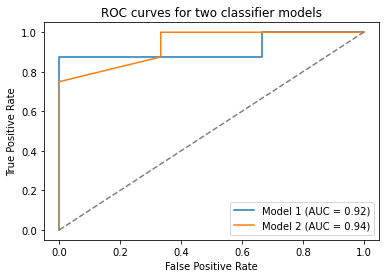

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ground truth labels
y_true = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

# predicted probabilities from model 1 and 2
y_prob1 = [0.1630, 0.0222, 0.0578, 0.0557, 0.9999, 0.9935, 0.9952, 0.9998, 0.9997, 0.6257, 0.9863]
y_prob2 = [0.6600, 0.6614, 0.6633, 0.6633, 0.6689, 0.6677, 0.6685, 0.6774, 0.6708, 0.6631, 0.6661]

# calculate false positive rate, true positive rate and thresholds for model 1 and 2
fpr1, tpr1, thresholds1 = roc_curve(y_true, y_prob1)
fpr2, tpr2, thresholds2 = roc_curve(y_true, y_prob2)

# calculate the AUC score for model 1 and 2
auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)

print(auc1)
print(auc2)
# plot ROC curves for model 1 and 2
plt.plot(fpr1, tpr1, label='Model 1 (AUC = %0.2f)' % auc1)
plt.plot(fpr2, tpr2, label='Model 2 (AUC = %0.2f)' % auc2)

# plot the 50-50 line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# set axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for two classifier models')
plt.legend()

# show the plot
plt.show()
